In [2]:
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords as nltk_stopwords
import time  

from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.naive_bayes import MultinomialNB

from scipy.stats import uniform
from scipy.stats import randint

import seaborn as sns
import string
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from nltk.stem import WordNetLemmatizer


from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer, StandardScaler

from sklearn.tree import export_graphviz
import graphviz

from sklearn.pipeline import Pipeline


from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd


In [12]:
# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') 
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gowthamkishorevijay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gowthamkishorevijay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gowthamkishorevijay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/gowthamkishorevijay/nltk_data...


In [13]:

# Load the CSV file (replace this path with your actual file path)
file_path = '/Users/gowthamkishorevijay/Desktop/Playground/projects/my-venv/CEAS_08.csv'  # Adjust based on your local environment
df = pd.read_csv(file_path)

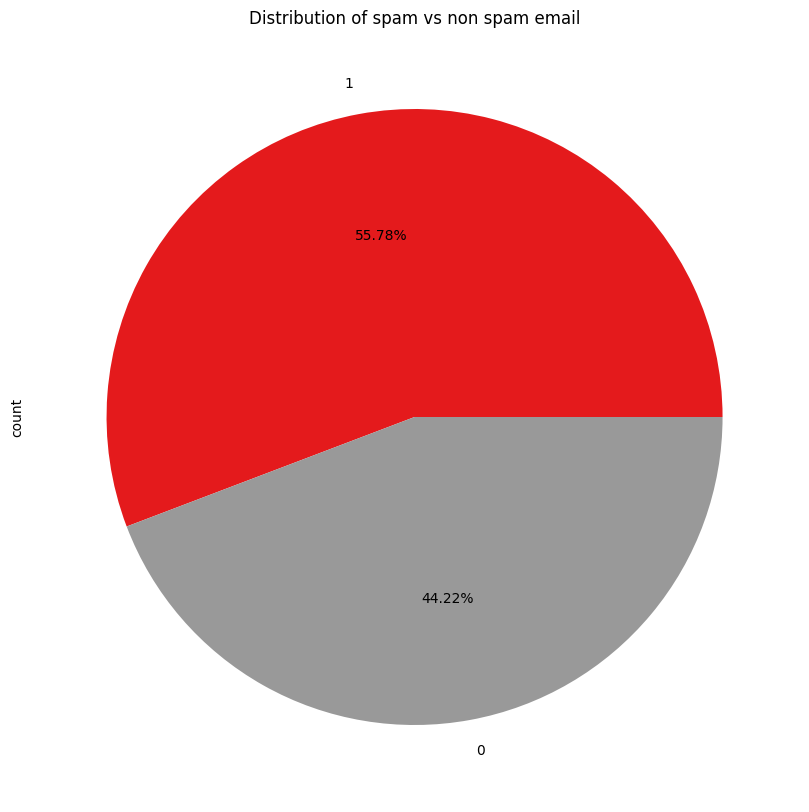

In [14]:
spread = df['label'].value_counts(dropna=True)
plt.rcParams['figure.figsize'] = (10,10)

# Set Labels
spread.plot(kind = 'pie', autopct='%1.2f%%', cmap='Set1')
plt.title(f'Distribution of spam vs non spam email')

# Display the Chart
plt.show()

In [15]:
def extract_urls(text):
    if not isinstance(text, str):
        return []
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    urls = re.findall(url_pattern, text)
    return urls

# Function to clean email body
def clean_text(text):
    if not isinstance(text, str):
       text = ''
    

    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'>+=+=+=+=+', '', text)  # Removing separators like '+=+=+=+=+=+'
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and digits
    
    # 3. Lowercase the text
    text = text.lower()
    
    # 4. Remove non-alphabetic characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 5. Remove stopwords
    text_tokens = text.split()
    filtered_words = [word for word in text_tokens if word not in stop_words]
    
    return ' '.join(filtered_words)

# Apply URL extraction and data cleaning
df['extracted_urls'] = df['body'].apply(extract_urls)
df['cleaned_body'] = df['body'].apply(clean_text)



print(df[['sender', 'subject', 'body', 'extracted_urls', 'label']].head())

                                              sender  \
0                   Young Esposito <Young@iworld.de>   
1                       Mok <ipline's1983@icable.ph>   
2  Daily Top 10 <Karmandeep-opengevl@universalnet...   
3                 Michael Parker <ivqrnai@pobox.com>   
4  Gretchen Suggs <externalsep1@loanofficertool.com>   

                                             subject  \
0                          Never agree to be a loser   
1                             Befriend Jenna Jameson   
2                               CNN.com Daily Top 10   
3  Re: svn commit: r619753 - in /spamassassin/tru...   
4                         SpecialPricesPharmMoreinfo   

                                                body  \
0  Buck up, your troubles caused by small dimensi...   
1  \nUpgrade your sex and pleasures with these te...   
2  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...   
3  Would anyone object to removing .so from this ...   
4  \nWelcomeFastShippingCustomerSupport\nhttp:

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/gowthamkishorevijay/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/gowthamkishorevijay/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/gowthamkishorevijay/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/gowthamkishorevijay/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/gowthamkishorevijay/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptr

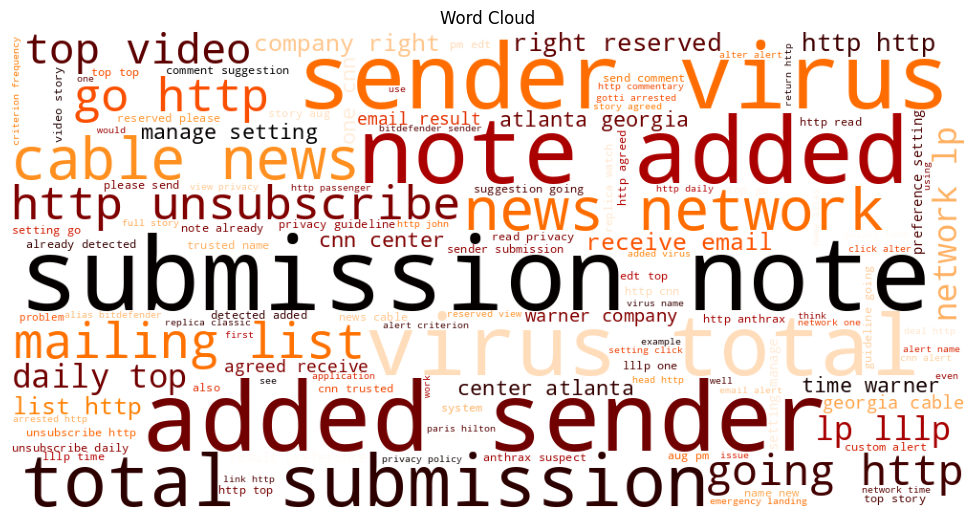

In [18]:

nltk.download('all')
for comment in df['body']:
    # Check if comment is a string
    if isinstance(comment, str):
        tokens = word_tokenize(comment.lower())  # Tokenize and convert to lowercase
        # Remove stopwords and non-alphabetic tokens, then lemmatize
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
        comment_words += " ".join(tokens) + " "

# Set Parameters for WordCloud
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    stopwords=stop_words,
    min_font_size=10,
    max_words=1000,
    colormap='gist_heat_r'
).generate(comment_words)

# Set Labels and Show the WordCloud
plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")  # Turn off axis
plt.title('Word Cloud')
plt.tight_layout(pad=0)
plt.show()

In [18]:
def evaluate_model_metrics(rand_search, X_train, y_train, X_test, y_test, computation_time):

    # Get predicted probabilities
    pred_prob_train = rand_search.predict_proba(X_train)[:, 1]
    pred_prob_test = rand_search.predict_proba(X_test)[:, 1]

    # Get binary predictions based on a threshold (e.g., 0.5)
    y_pred_train = np.where(pred_prob_train > 0.5, 1, 0)
    y_pred_test = np.where(pred_prob_test > 0.5, 1, 0)

    # Calculate ROC AUC score
    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    roc_auc_test = roc_auc_score(y_test, y_pred_test)

    # Plot the ROC curve
    fpr_train, tpr_train, _ = roc_curve(y_train, pred_prob_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, pred_prob_test)

    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_train, tpr_train, label="Train ROC AUC: {:.2f}".format(roc_auc_train))
    plt.plot(fpr_test, tpr_test, label="Test ROC AUC: {:.2f}".format(roc_auc_test))
    plt.legend()
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    plt.show()

    # Calculate confusion matrix
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    fig, ax = plt.subplots(1, 2, figsize=(11, 4))

    sns.heatmap(cm_train, annot=True, fmt='d', cmap="Oranges", ax=ax[0], 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")
    ax[0].set_title("Train Confusion Matrix")

    sns.heatmap(cm_test, annot=True, fmt='d', cmap="Oranges", ax=ax[1], 
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    ax[1].set_xlabel("Predicted Label")
    ax[1].set_ylabel("True Label")
    ax[1].set_title("Test Confusion Matrix")

    plt.tight_layout()
    plt.show()

    # Calculate metrics
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_train = precision_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)
    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)
    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)

    # Display the classification report
    classification_report_train = classification_report(y_train, y_pred_train, 
                                                         target_names=['Negative', 'Positive'])
    classification_report_test = classification_report(y_test, y_pred_test, 
                                                       target_names=['Negative', 'Positive'])

    # Print the results
    print(f"Time taken for evaluation: {computation_time:.2f} seconds\n")
    
    print("ROC AUC Scores")
    print(f"Train ROC AUC: {roc_auc_train}")
    print(f"Test ROC AUC: {roc_auc_test}\n")

    print("Accuracy Scores")
    print(f"Train Accuracy: {accuracy_train}")
    print(f"Test Accuracy: {accuracy_test}\n")

    print("Precision Scores")
    print(f"Train Precision: {precision_train}")
    print(f"Test Precision: {precision_test}\n")
    
    print("F1 Scores")
    print(f"Train F1 Score: {f1_train}")
    print(f"Test F1 Score: {f1_test}\n")

    print("Recall Scores")
    print(f"Train Recall Score: {recall_train}")
    print(f"Test Recall Score: {recall_test}\n")

    print("Classification Report (Train):\n", classification_report_train)
    print("\nClassification Report (Test):\n", classification_report_test)


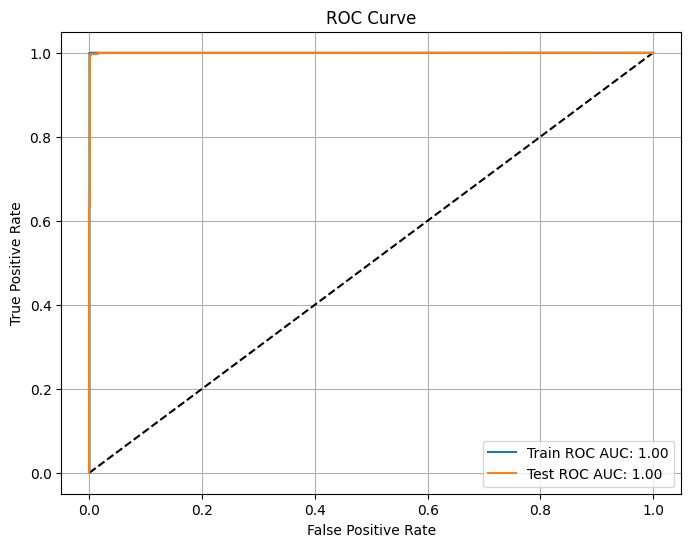

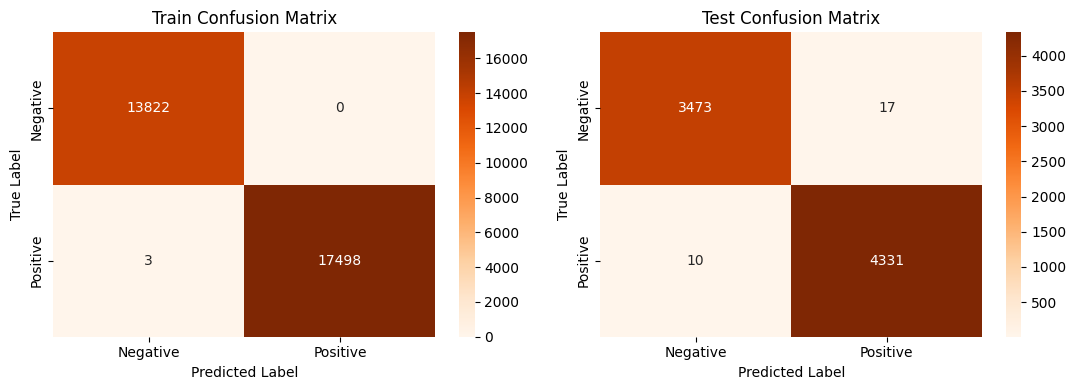

Time taken for evaluation: 15.20 seconds

ROC AUC Scores
Train ROC AUC: 0.999914290611965
Test ROC AUC: 0.9964126615749477

Accuracy Scores
Train Accuracy: 0.9999042237333589
Test Accuracy: 0.9965521644745243

Precision Scores
Train Precision: 1.0
Test Precision: 0.9960901563937442

F1 Scores
Train F1 Score: 0.9999142832652361
Test F1 Score: 0.9968926228564852

Recall Scores
Train Recall Score: 0.99982858122393
Test Recall Score: 0.9976963833218152

Classification Report (Train):
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00     13822
    Positive       1.00      1.00      1.00     17501

    accuracy                           1.00     31323
   macro avg       1.00      1.00      1.00     31323
weighted avg       1.00      1.00      1.00     31323


Classification Report (Test):
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      3490
    Positive       1.00      1.00      1.00   

In [19]:
X = df[['cleaned_body', 'extracted_urls']]
y = df['label']  # Ensure y is numeric for regression tasks

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
start_time = time.time();

# Preprocessor: handling 'body' and 'extracted_urls' separately
preprocessor = ColumnTransformer(
    transformers=[
        ('body', Pipeline([
            ('convert_to_str', FunctionTransformer(lambda x: x.astype(str), validate=False)),
            ('tfidf', TfidfVectorizer(min_df=1, max_df=0.9))
        ]), 'cleaned_body'),
        ('extracted_urls', Pipeline([
            ('convert_to_str', FunctionTransformer(lambda x: x.astype(str), validate=False)),
            ('tfidf', TfidfVectorizer())
        ]), 'extracted_urls'),
        # For 'message_length' column: calculate the length of the message body
        ('message_length', Pipeline([
            ('length', FunctionTransformer(lambda X: np.array(X.apply(len)).reshape(-1, 1))),  # Reshape to 2D
            ('scaler', StandardScaler())
        ]), 'cleaned_body')  
    ])

# Create the full pipeline with Linear Regression
model = Pipeline([
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression(max_iter=1000))
])


# Define hyperparameter distributions for Logistic Regression
param_dist = {
    'log_reg__C': [0.1, 1.0, 10],
    'log_reg__penalty': ['l2'],
    'log_reg__solver': ['lbfgs']
}

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(model, 
                                 param_distributions=param_dist, 
                                 n_iter=3,  # Increase n_iter for more combinations
                                 cv=3, 
                                 random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

evaluate_model_metrics(rand_search, X_train, y_train, X_test, y_test, time.time() - start_time)





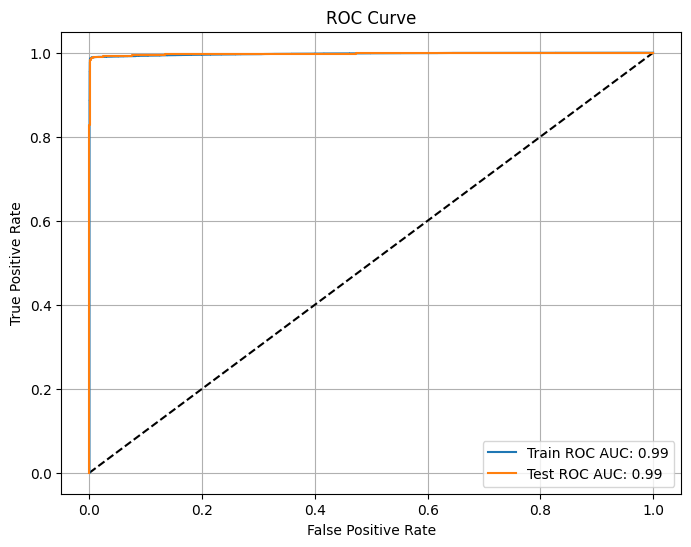

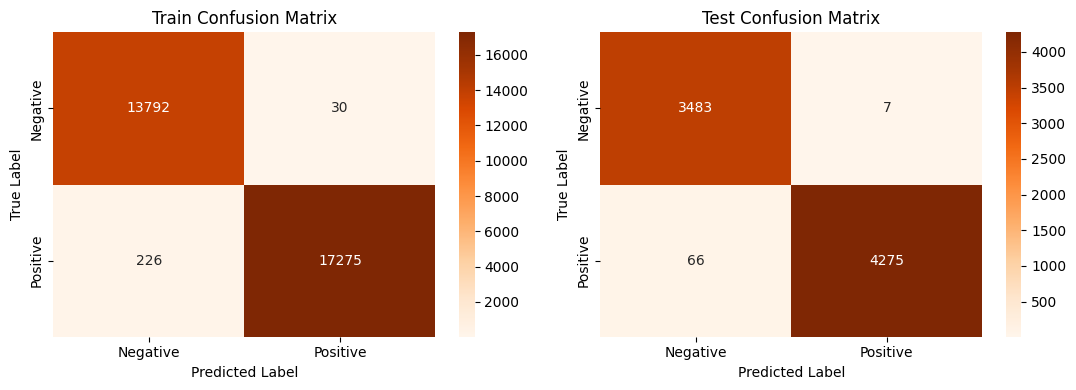

Time taken for evaluation: 34.53 seconds

ROC AUC Scores
Train ROC AUC: 0.9924579996507797
Test ROC AUC: 0.9913951996324775

Accuracy Scores
Train Accuracy: 0.9918270919132905
Test Accuracy: 0.9906780743200102

Precision Scores
Train Precision: 0.9982663969950881
Test Precision: 0.9983652498832322

F1 Scores
Train F1 Score: 0.992644946273631
Test F1 Score: 0.9915342688159573

Recall Scores
Train Recall Score: 0.9870864522027313
Test Recall Score: 0.9847961299239807

Classification Report (Train):
               precision    recall  f1-score   support

    Negative       0.98      1.00      0.99     13822
    Positive       1.00      0.99      0.99     17501

    accuracy                           0.99     31323
   macro avg       0.99      0.99      0.99     31323
weighted avg       0.99      0.99      0.99     31323


Classification Report (Test):
               precision    recall  f1-score   support

    Negative       0.98      1.00      0.99      3490
    Positive       1.00      

In [20]:

X = df[['cleaned_body', 'extracted_urls']]
y = df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start_time = time.time();
# Preprocessor: handling 'body' and 'extracted_urls' separately
preprocessor = ColumnTransformer(
    transformers=[
        ('body', Pipeline([
            ('convert_to_str', FunctionTransformer(lambda x: x.astype(str), validate=False)),
            ('tfidf', TfidfVectorizer(min_df=1, max_df=0.9))
        ]), 'cleaned_body'),
        ('extracted_urls', Pipeline([
            ('convert_to_str', FunctionTransformer(lambda x: x.astype(str), validate=False)),
            ('tfidf', TfidfVectorizer())
        ]), 'extracted_urls'),
         # For 'message_length' column: calculate the length of the message body
        ('message_length', Pipeline([
            ('length', FunctionTransformer(lambda X: np.array(X.apply(len)).reshape(-1, 1)))  # Reshape to 2D
        ]), 'cleaned_body')  
    ])

# Create the full pipeline with MultinomialNB


model = Pipeline([
    ('preprocessor', preprocessor),
    ('nb', MultinomialNB())
])

# Define hyperparameter distributions (alpha parameter for smoothing in MultinomialNB)
param_dist = {
    'nb__alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
}

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(model, 
                                 param_distributions=param_dist, 
                                 n_iter=5, 
                                 cv=5, 
                                 random_state=42)  # Added random_state for reproducibility

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

evaluate_model_metrics(rand_search, X_train, y_train, X_test, y_test, time.time() - start_time)


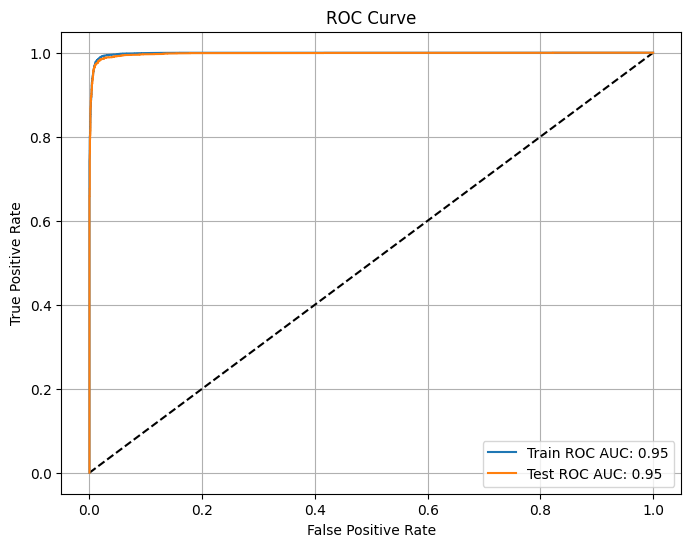

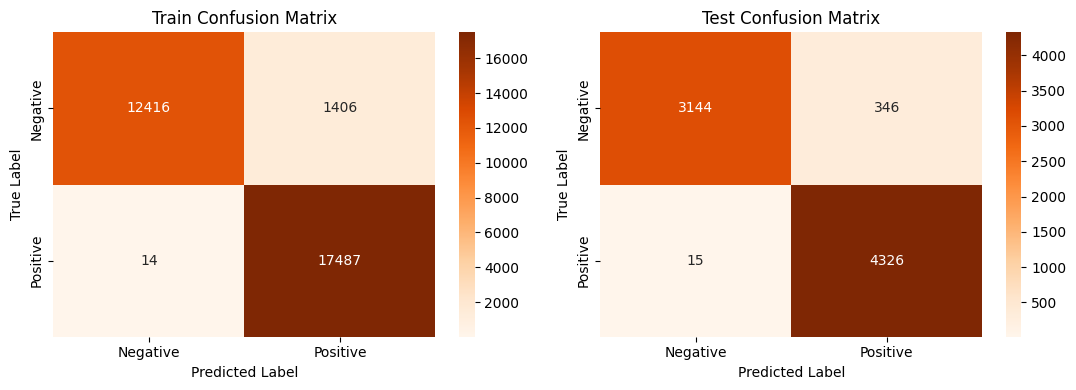

Time taken for evaluation: 88.93 seconds

ROC AUC Scores
Train ROC AUC: 0.9487390765383719
Test ROC AUC: 0.9487020869182955

Accuracy Scores
Train Accuracy: 0.9546659004565335
Test Accuracy: 0.9539011620482697

Precision Scores
Train Precision: 0.9255809029799397
Test Precision: 0.9259417808219178

F1 Scores
Train F1 Score: 0.960982579546079
Test F1 Score: 0.9599467435925885

Recall Scores
Train Recall Score: 0.9992000457116736
Test Recall Score: 0.9965445749827229

Classification Report (Train):
               precision    recall  f1-score   support

    Negative       1.00      0.90      0.95     13822
    Positive       0.93      1.00      0.96     17501

    accuracy                           0.95     31323
   macro avg       0.96      0.95      0.95     31323
weighted avg       0.96      0.95      0.95     31323


Classification Report (Test):
               precision    recall  f1-score   support

    Negative       1.00      0.90      0.95      3490
    Positive       0.93      

In [27]:
# Features and labels


## For Random forest classifier
X = df[['cleaned_body', 'extracted_urls']]
y = df['label']

def message_length(X):
    return X.apply(len)


def column_as_string(X):
    return X.astype(str)


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
start_time = time.time();

# Preprocessor: handling 'body' and 'extracted_urls' separately
preprocessor = ColumnTransformer(
    transformers=[
        ('body', Pipeline([
            ('convert_to_str', FunctionTransformer(lambda x: x.astype(str), validate=False)),
            ('tfidf', TfidfVectorizer(min_df=1, max_df=0.9))
        ]), 'cleaned_body'),
        ('extracted_urls', Pipeline([
            ('convert_to_str', FunctionTransformer(lambda x: x.astype(str), validate=False)),
            ('tfidf', TfidfVectorizer())
        ]), 'extracted_urls'),
         # For 'message_length' column: calculate the length of the message body
       ('message_length', Pipeline([
            ('length', FunctionTransformer(lambda X: np.array(X.apply(len)).reshape(-1, 1)))  # Reshape to 2D
        ]), 'cleaned_body')  
    ])



model = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier())
])

# Define hyperparameter distributions
param_dist = {
    'rf__n_estimators': randint(50, 500),  # Use randint for a distribution of values
    'rf__max_depth': randint(1, 20)        # Use randint for a distribution of values
}

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(model, 
                                 param_distributions=param_dist, 
                                 n_iter=6, 
                                 cv=5, 
                                 random_state=42)  # Added random_state for reproducibility

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

evaluate_model_metrics(rand_search, X_train, y_train, X_test, y_test, time.time() - start_time)

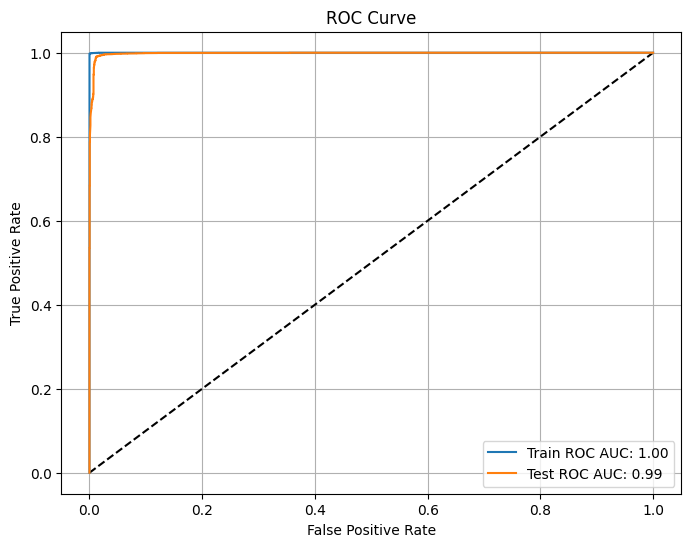

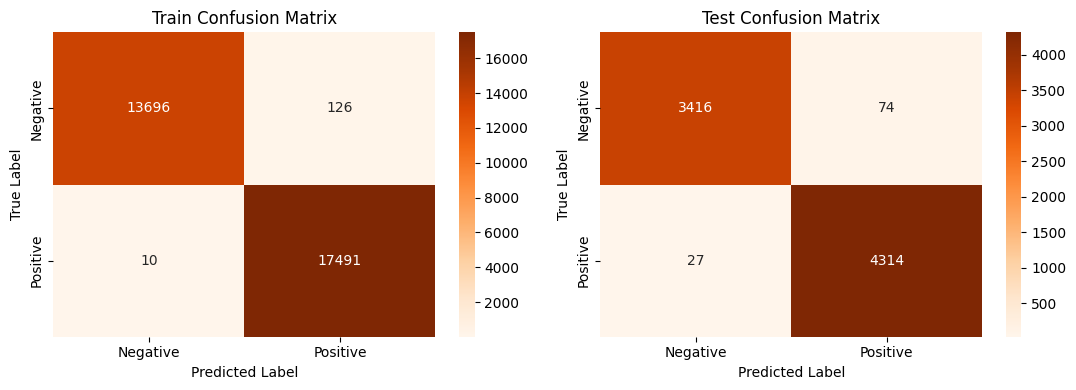

Time taken for evaluation: 315.17 seconds

ROC AUC Scores
Train ROC AUC: 0.995156350947422
Test ROC AUC: 0.9862883982867429

Accuracy Scores
Train Accuracy: 0.9956581425789356
Test Accuracy: 0.9871025411824799

Precision Scores
Train Precision: 0.9928478174490549
Test Precision: 0.9831358249772105

F1 Scores
Train F1 Score: 0.9961273421037644
Test F1 Score: 0.9884293733531905

Recall Scores
Train Recall Score: 0.9994286040797669
Test Recall Score: 0.9937802349689012

Classification Report (Train):
               precision    recall  f1-score   support

    Negative       1.00      0.99      1.00     13822
    Positive       0.99      1.00      1.00     17501

    accuracy                           1.00     31323
   macro avg       1.00      1.00      1.00     31323
weighted avg       1.00      1.00      1.00     31323


Classification Report (Test):
               precision    recall  f1-score   support

    Negative       0.99      0.98      0.99      3490
    Positive       0.98     

In [29]:


# Assuming df is your DataFrame with features and labels
X = df[['cleaned_body', 'extracted_urls']]
y = df['label']

# Function to calculate message length
def message_length(X):
    return X.apply(len)

# Split the dataset into training and testing sets
start_time = time.time();
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessor: handling 'body' and 'extracted_urls' separately
preprocessor = ColumnTransformer(
    transformers=[
        ('body', Pipeline([
            ('convert_to_str', FunctionTransformer(lambda x: x.astype(str), validate=False)),
            ('tfidf', TfidfVectorizer(min_df=1, max_df=0.9))
        ]), 'cleaned_body'),
        ('extracted_urls', Pipeline([
            ('convert_to_str', FunctionTransformer(lambda x: x.astype(str), validate=False)),
            ('tfidf', TfidfVectorizer())
        ]), 'extracted_urls'),
        # For 'message_length' column: calculate the length of the message body
        ('message_length', Pipeline([
            ('length', FunctionTransformer(lambda X: np.array(X.apply(len)).reshape(-1, 1)))  # Reshape to 2D
        ]), 'cleaned_body')  
    ])

# Create the full pipeline with GradientBoostingClassifier
model = Pipeline([
    ('preprocessor', preprocessor),
    ('gb', GradientBoostingClassifier())
])

# Define hyperparameter distributions for Gradient Boosting
param_dist = {
    'gb__n_estimators': np.arange(50, 101, 50),  # Number of trees: 50 and 100
    'gb__max_depth': np.arange(1, 11),           # Maximum depth: from 1 to 10
    'gb__learning_rate': [0.01, 0.05, 0.1, 0.2], # Learning rates
    'gb__subsample': [0.5, 0.75, 1.0]            # Subsampling options
}

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(model, 
                                 param_distributions=param_dist, 
                                 n_iter=2, 
                                 cv=2, 
                                 random_state=42)  # Added random_state for reproducibility

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

evaluate_model_metrics(rand_search, X_train, y_train, X_test, y_test, time.time() - start_time)


In [ ]:
new_email_body = """hey mate...."""

# Apply the same preprocessing steps (extract URLs and clean text)
new_email_body = clean_text(new_email_body)  # Clean the email body
new_email_urls = extract_urls(new_email_body)  # Extract URLs
new_email_length = len(new_email_body)  # Calculate the length of the email body

# Create a DataFrame similar to the one used for training
new_email_df = pd.DataFrame({
    'body': [new_email_body],  # Cleaned email body
    'extracted_urls': [' '.join(new_email_urls)],  # Join extracted URLs into a single string
    'message_length': [new_email_length]  # Include the message length
})

# Make a prediction using the model pipeline
prediction = rand_search.predict(new_email_df)

# Print the prediction result
if prediction == 0:
    print("This is not a spam Email!")
else:
    print("This is a Spam Email!")
